In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path('original')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != '.DS_Store']
print('Commands:', commands)

Commands: ['neg' 'pos']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Metal device set to: Apple M1
Number of total examples: 16
Number of examples per label: 9
Example file tensor: tf.Tensor(b'original/neg/neg-0421-089-cough-f-20.wav', shape=(), dtype=string)


2022-07-13 17:19:12.314973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-13 17:19:12.315089: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
filenames

<tf.Tensor: shape=(16,), dtype=string, numpy=
array([b'original/neg/neg-0421-089-cough-f-20.wav',
       b'original/pos/pos-0421-084-cough-m-50.wav',
       b'original/pos/pos-0421-094-cough-m-51.wav',
       b'original/neg/neg-0421-090-cough-f-17.wav',
       b'original/neg/neg-0421-085-cough-m-43.wav',
       b'original/neg/neg-0422-098-cough-f-24.wav',
       b'original/neg/neg-0421-083-cough-m-53.wav',
       b'original/pos/pos-0421-087-cough-f-40.wav',
       b'original/neg/neg-0422-097-cough-m-37.wav',
       b'original/neg/neg-0421-088-cough-f-66.wav',
       b'original/neg/neg-0421-091-cough-m-47.wav',
       b'original/pos/pos-0421-086-cough-m-65.wav',
       b'original/pos/pos-0421-092-cough-m-53.wav',
       b'original/pos/pos-0422-096-cough-m-31.wav',
       b'original/neg/neg-0422-095-cough-m-53.wav',
       b'original/pos/pos-0421-093-cough-f-24.wav'], dtype=object)>

In [6]:
train_files = filenames
print('Training set size', len(train_files))


Training set size 16


In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

2022-07-13 17:19:12.470276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-13 17:19:12.472218: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


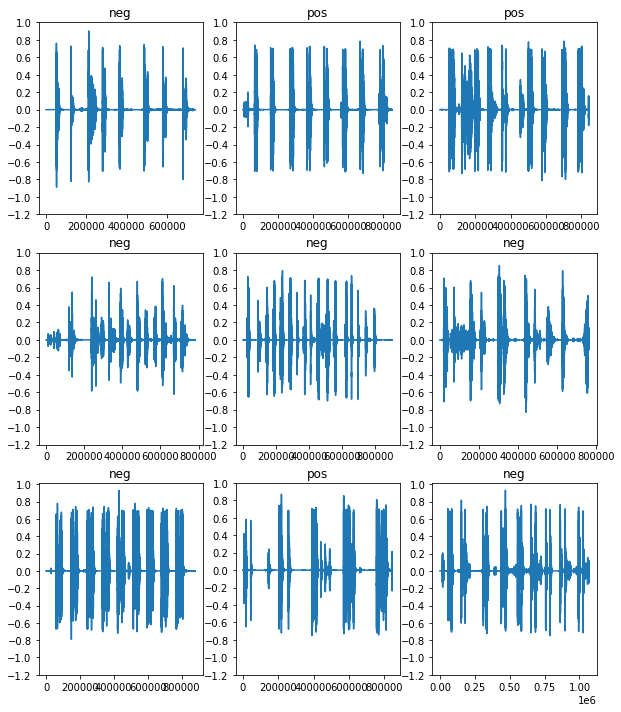

In [9]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [10]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([1999376] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [11]:
for waveform, label in waveform_ds.take(3):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: pos
Waveform shape: (843776,)
Spectrogram shape: (15619, 129)
Audio playback


In [12]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [13]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds
train_ds = spectrogram_ds

In [14]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)

In [15]:
for i in range(16):
    for spectrogram, _ in spectrogram_ds.take(i):
      print(spectrogram.shape)

(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 129, 1)
(15619, 

In [16]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    #layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.Dropout(0.25),
    layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (15619, 129, 1)


2022-07-13 17:19:21.257306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-13 17:19:21.267487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 14402     
Total params: 14,725
Trainable params: 14,722
Non-trainable params: 3
____________________________________________________

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [18]:
train_ds

<PrefetchDataset shapes: ((None, None, 129, 1), (None,)), types: (tf.float32, tf.int64)>

In [19]:
EPOCHS = 10
history = model.fit(
    train_ds,   
    epochs=EPOCHS,
)

Epoch 1/10


2022-07-13 17:19:22.063937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 797ms/step - loss: 0.7100 - accuracy: 0.7500
Epoch 2/10
1/1 [==============================] - 0s 15ms/step - loss: 0.6343 - accuracy: 0.6875
Epoch 3/10
1/1 [==============================] - 0s 25ms/step - loss: 0.5839 - accuracy: 0.6875
Epoch 4/10
1/1 [==============================] - 0s 15ms/step - loss: 0.5384 - accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 0s 16ms/step - loss: 0.4960 - accuracy: 0.7500
Epoch 6/10
1/1 [==============================] - 0s 17ms/step - loss: 0.4590 - accuracy: 0.8125
Epoch 7/10
1/1 [==============================] - 0s 21ms/step - loss: 0.4277 - accuracy: 0.9375
Epoch 8/10
1/1 [==============================] - 0s 16ms/step - loss: 0.4007 - accuracy: 0.9375
Epoch 9/10
1/1 [==============================] - 0s 15ms/step - loss: 0.3760 - accuracy: 0.9375
Epoch 10/10
1/1 [==============================] - 0s 20ms/step - loss: 0.3525 - accuracy: 0.9375
